In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
from scipy import stats
from collections import Counter, defaultdict
from functools import reduce

In [2]:
# Define clonotype field names
# - V gene, J gene, CDR3 length
clonotype_filter = ["V-GENE", "J-GENE", "CDR3_len"]
def clonotype_format(x): return "{}.{}.CDR3_len{}".format(*x)

In [104]:
# Get list of sample clonotypes
summary_files = list(glob.iglob(
    "/nfs/users/nfs_b/bb9/workspace/rotation2/team115_lustre/data/existing_bcr_data/MalariaSamplesBen/**/*_Summary.txt", 
    recursive=True, 
)) #+ ["/nfs/users/nfs_b/bb9/workspace/rotation2/team115_lustre/data/2017-02-06_IMGT_LEA_S20/Day63/LEA_S20_Summary.txt"]

# Extract sample day and number from filename
p = re.compile(r'Day(\d+)/LEA_S(\d+)_Summary.txt')
days = [p.search(f).group(1) for f in summary_files]
sample_nums = [p.search(f).group(2) for f in summary_files]

# Read in all summary files
summary_df = pd.concat(
    (pd.read_table(f, header=0, usecols=list(range(0,30))) for f in summary_files),
    keys=zip(days, sample_nums),
    names=["day", "sample_num"]
)
summary_df.index.names = pd.core.base.FrozenList(['day', 'sample_num', 'seq_i'])

# Count unique BCRs per sample
# print(summary_df.groupby(level="sample_num").apply(lambda x: x.shape))

# List possible Functionalities
# print(summary_df["Functionality"].unique())
# Filter out unproductive and "No results"
summary_df = summary_df[summary_df["Functionality"].isin(['productive', 'productive (see comment)'])]

# Count unique BCRs per sample after filter
# print(summary_df.groupby(level="sample_num").apply(lambda x: x.shape))

# Convert row indices into columns
summary_df = summary_df.reset_index(level=summary_df.index.names)
del summary_df["seq_i"]

# Get V J gene assignments by taking the first assignment, collapsing alleles.
summary_df["V-GENE"] = [x.split(", or ")[0].split("*")[0].replace("Homsap ", "") for x in summary_df["V-GENE and allele"]]
summary_df["J-GENE"] = [x.split(", or ")[0].split("*")[0].replace("Homsap ", "") for x in summary_df["J-GENE and allele"]]

summary_df["CDR3_len"] = summary_df["CDR3-IMGT length"]
summary_df[["day", "sample_num"]] = summary_df[["day", "sample_num"]].apply(pd.to_numeric)

# Get clonotypes for known mAbs
mAb_df = pd.read_csv("/nfs/users/nfs_b/bb9/workspace/rotation2/team115_lustre/data/existing_bcr_data/MalariaSamplesBen/IgBlast_bnAbs.csv")
mAb_df["V-GENE"] = [x.split(",")[0].split("*")[0] for x in mAb_df["V gene"]]
mAb_df["J-GENE"] = [x.split(",")[0].split("*")[0] for x in mAb_df["J gene"]]
mAb_df["VJ-GENE"] = mAb_df["V-GENE"] + "." + mAb_df["J-GENE"]
mAb_df["CDR3_len"] = mAb_df["CDR3 amino acid seq"].map(len)
mAb_df["clonotype"] = mAb_df[clonotype_filter].apply(clonotype_format, axis=1)

# Get clonotypes for existing data
summary_df["clonotype"] = summary_df[clonotype_filter].apply(clonotype_format, axis=1)
summary_df["VJ-GENE"] = summary_df["V-GENE"] + "." + summary_df["J-GENE"]

# Read in sample information
sample_info_df = pd.read_excel("/nfs/users/nfs_b/bb9/workspace/rotation2/team115_lustre/data/existing_bcr_data/MalariaSamplesBen/Malaria_Samples_SeqInfo.xlsx")
sample_info_df["patient_code"] = sample_info_df["patient_code"].astype("category")

# Calculate normalisation factor per sample.
# If a sample has an above average number of reads, 
# the contribution to normalised clonotype abundance by that sample should be lower.
sample_info_df["norm_factor"] = np.mean(sample_info_df["Reads, count"]) / sample_info_df["Reads, count"]

# Merge in patient number and cell type
summary_df = pd.merge(summary_df, sample_info_df[["Tag Index", "patient_code", "cell_type", "norm_factor"]], 
         how="left", left_on="sample_num", right_on="Tag Index")

# Merge correspondance to known mAbs
summary_df = pd.merge(summary_df, mAb_df[["Ab.Name", "clonotype"]], 
         how="left", on="clonotype")

# Check if V-gene is in the set of V-genes used in known mAbs
summary_df["V-GENE_known_usage"] = np.where(summary_df["V-GENE"].isin(mAb_df["V-GENE"]), summary_df["V-GENE"], "NaN")

# Mark clones with multiple isotypes
summary_df["isotypes"] = summary_df["digest"].map(lambda x: x.split("/"))
summary_df["n_isotypes"] = summary_df["isotypes"].map(len)

# Calculate mutational freq per base pair
summary_df["V-REGION_unmut_len"] = summary_df["V-REGION identity nt"].map(lambda x: int(x.split()[0].split('/')[0]))
summary_df["J-REGION_unmut_len"] = summary_df["J-REGION identity nt"].map(lambda x: int(x.split()[0].split('/')[0]))
summary_df["VJ-REGION_unmut_len"] = summary_df["V-REGION_unmut_len"] + summary_df["J-REGION_unmut_len"]

summary_df["V-REGION_len"] = summary_df["V-REGION identity nt"].map(lambda x: int(x.split()[0].split('/')[1]))
summary_df["J-REGION_len"] = summary_df["J-REGION identity nt"].map(lambda x: int(x.split()[0].split('/')[1]))
summary_df["VJ-REGION_len"] = summary_df["V-REGION_len"] + summary_df["J-REGION_len"]

summary_df["mut_freq_per_bp_v"] = (
    (summary_df["V-REGION_len"] - summary_df["V-REGION_unmut_len"])
    /summary_df["V-REGION_len"]
    /summary_df["V-REGION_len"]
)
summary_df["mut_freq_per_bp_j"] = (
    (summary_df["J-REGION_len"] - summary_df["J-REGION_unmut_len"])
    /summary_df["J-REGION_len"]
    /summary_df["J-REGION_len"]
)
summary_df["mut_freq_per_bp_vj"] = (
    (summary_df["VJ-REGION_len"] - summary_df["V-REGION_unmut_len"] - summary_df["J-REGION_unmut_len"])
    / summary_df["VJ-REGION_len"]
    / summary_df["VJ-REGION_len"]
)

# Questions to ask

How is immunity to the vaccine candidate achieved? Due to antibodies... which we detect via:

- V-gene usage
- clonotype abundance
- mutational frequency

Things:

- V(D)J gene frequencies, Ig isotype usage, and BCR clone size, stratified by timepoint and patient
- Look for expansion of clonotypes in day 63 and 140 vs. day 0
- Compare expanded clonotypes to known Ab sequences
- Look for differences between patients at day 0
- Calculate mutational frequencies of clonotypes
- Area/bar/parallel coords chart showing expansion of clonotypes (known V genes?) over time
- 1 long stream plot showing abundances of clones over time in the 3 individuals

## Comparison across individuals at pre-prime (day 0)

RH5 and Duffy samples

- Distribution of clonotypes between individuals
- How diverse is the repertoire? Gini index?
- Run comparison across cell types

## Clonotypes at early post prime (day 28)

Look for:

- clonotype freq
- isotype distribution
- mutational freq (1-% identity) vs. IMGT V gene reference
    - linear regression of BCR mutational frequency against clonotype V gene status
    - mutational freq stratified by isotype
    
In the compartments:

- For memory cells vs day 0
- For plasmablasts vs naive repertoire (IgD/IgM unmutated sequences taken from PBMC samples at Day 0)

- Are expanded/mutated clonotypes the same as the
    - known anti-RH5 Ab sequences
    - ones observed in AMA1 and Duffy trials
    - ones observed in influenza and other infection challenge

## Clonotypes at early post boost (day 63)

Look for:

- clonotype freq
- isotype distribution
- mutational freq (1-% identity) vs. IMGT V gene reference
    - linear regression of BCR mutational frequency against clonotype V gene status
    - mutational freq stratified by isotype
    
In the compartments:

- For memory cells vs day 0 and day 28
- For plasmablasts vs plasmoblasts at day 0 and day 28
    - activation of same clonotypes during prime and boost?
- For plasmablasts vs naive repertoire at day 0 and day 28
- For plasmablasts vs memory repertoire at day 0 and day 28
    - recall of memory cells generated at the prime?

- clonotype overlap between 

## Clonotypes at long term (day 140)

Look for:

- clonotype freq

In the compartments:

- For plasmablasts vs memory repertoire at day 63
    - how much of the boost response is detectable in long term memory?

## Identification of malaria specific mAbs

- Overlap with known anti RH5 mAbs (isolated from day 63), or clonotypes appearing in other infections/vaccinations in the literature
- Can we expect cross-reactivity in clonotypes that would affect the inferences based on the BCR repertoire data? 

In [4]:
# Generate counts matrices: biological unit by samples

# Biological unit: clonotype
count_clonotype =  summary_df.groupby(["sample_num", "clonotype"]).apply(len).unstack().transpose().fillna(0)
count_clonotype.to_csv("../team115_lustre/1_analyse_clonotypes/count_clonotype.csv")

# Biological unit: vj gene combo
count_vj =  summary_df.groupby(["sample_num", "VJ-GENE"]).apply(len).unstack().transpose().fillna(0)
count_vj.to_csv("../team115_lustre/1_analyse_clonotypes/count_vj.csv")

# Write out sample information csv
sample_info_df.to_csv("../team115_lustre/1_analyse_clonotypes/sample_info.csv", index=False)


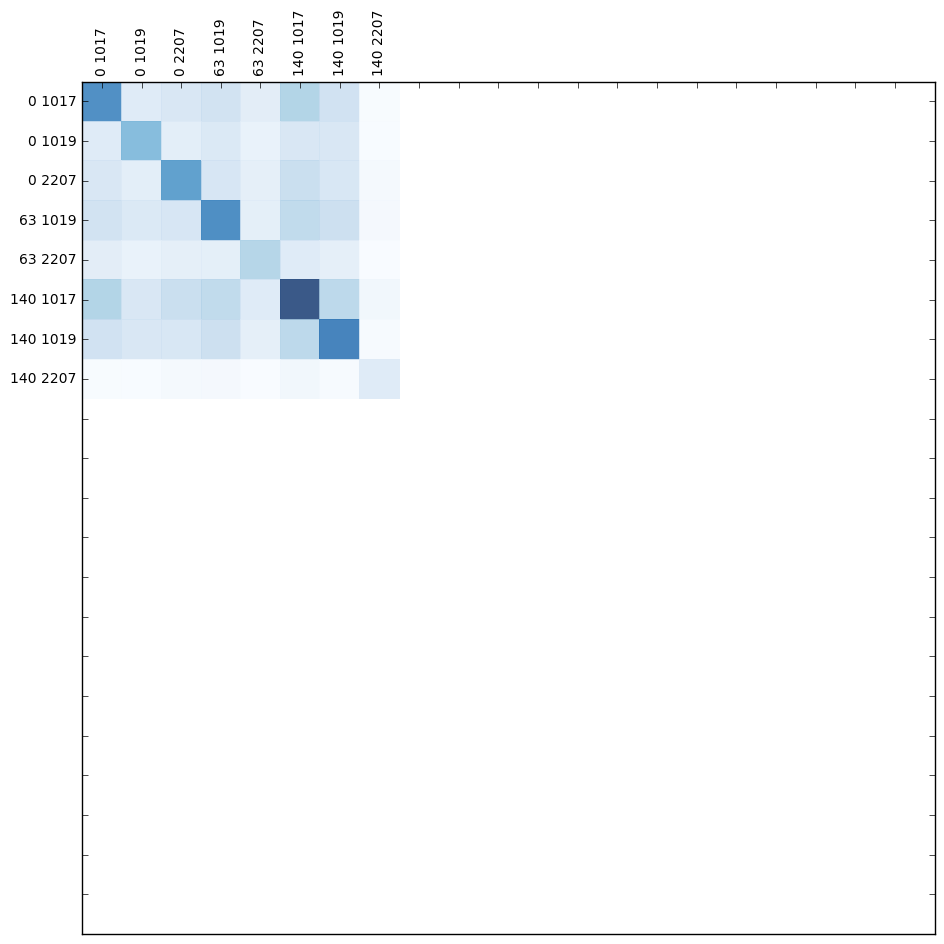

In [85]:
# Heatmap: sharing of unique clonotypes between individuals by time and cell type

# foo = summary_df.groupby(["patient_code", "cell_type", "day"]).apply(lambda x: set(x["clonotype"]))

foo = summary_df.query("cell_type == 'MBC'").groupby(["day", "patient_code"]).apply(lambda x: set(x["clonotype"]))

bar = np.reshape([len(x.intersection(y)) for x in foo for y in foo], newshape=(len(foo), len(foo)))

fig, ax = plt.subplots()
heatmap = ax.pcolor(bar, cmap=plt.cm.Blues, alpha=0.8)

fig.set_size_inches(11, 11)

baz = (foo.keys().levels[0][foo.keys().labels[0]].astype("str")
 + " "
 + foo.keys().levels[1][foo.keys().labels[1]].astype("str")
#  + " "
#  + foo.keys().levels[2][foo.keys().labels[2]].astype("str")
      )

ax.set_xticks(np.arange(22) + 0.5, minor=False)
ax.set_yticks(np.arange(22) + 0.5, minor=False)

ax.set_xticklabels(baz, minor=False)
ax.set_yticklabels(baz, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

plt.xticks(rotation=90)

plt.show()

In [94]:
adj = pd.DataFrame(bar)
adj.columns = baz
adj.to_csv("../team115_lustre/1_analyse_clonotypes/adj.csv", index=False)
adj

,0 1017,0 1019,0 2207,63 1019,63 2207,140 1017,140 1019,140 2207
0,559,148,178,210,135,299,216,43
1,148,396,128,166,103,176,176,38
2,178,128,503,185,121,236,181,52
3,210,166,185,565,125,261,227,57
4,135,103,121,125,290,151,122,35
5,299,176,236,261,151,751,271,66
6,216,176,181,227,122,271,600,48
7,43,38,52,57,35,66,48,148


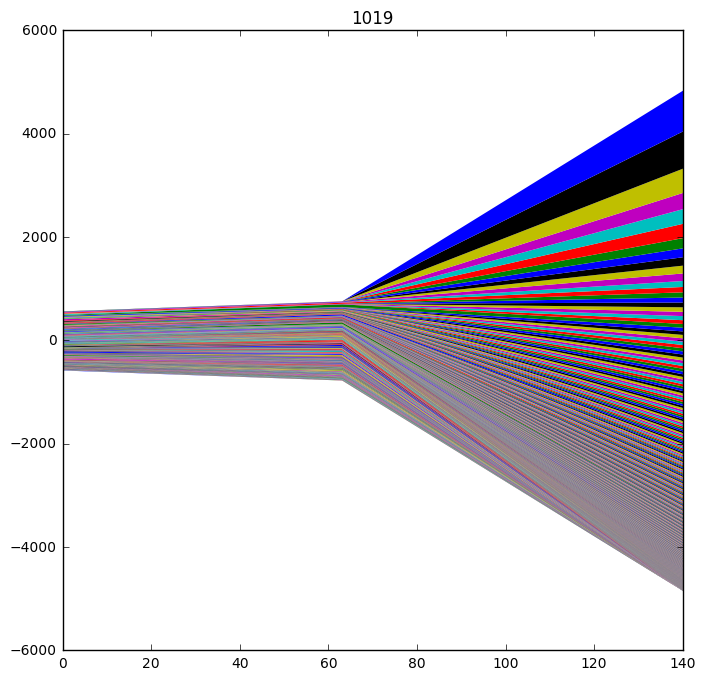

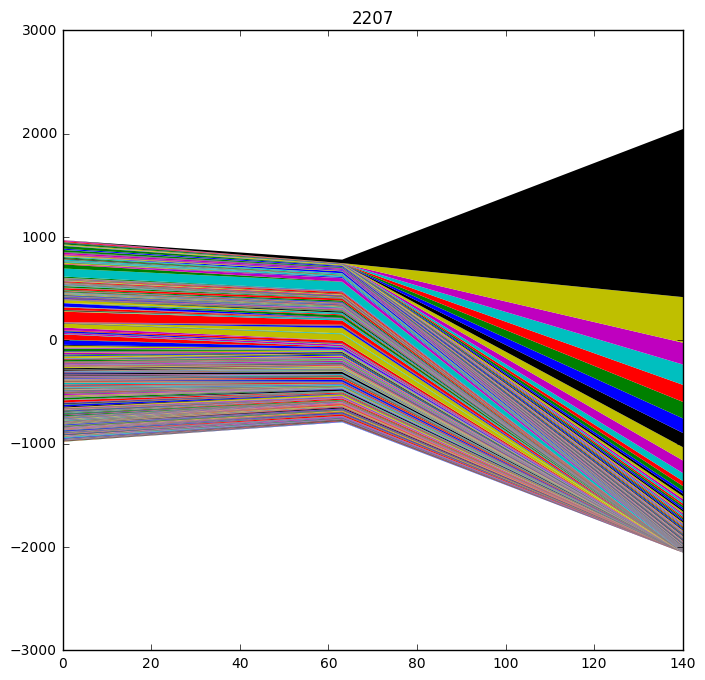

In [84]:
# Plot clonotype abundances in each cell type, per patient, over time

for patient_code in ["1019", "2207"]:
# for patient_code in summary_df["patient_code"].unique():
    # Get clonotype count for each unique clonotype at each timepoint
    foo = summary_df.query("patient_code == {} & cell_type == 'MBC'".format(patient_code)).groupby(["day", "clonotype"]).apply(lambda x: x["norm_factor"].sum()).unstack().transpose().fillna(0)
    # Sort by freq at day 140
    foo.sort_values([140], ascending=True, inplace=True)
    days = np.array([0, 63, 140])
    fig, ax = plt.subplots()
    ax.stackplot(days, foo, baseline="sym", linewidth=0) 
    fig.set_size_inches(8, 8)
    plt.title(patient_code)
    plt.show()

In [50]:
def get_naive_rep(summary_df):
    '''Filter for the naive repertoire
    '''
    return summary_df.loc[(summary_df["V-REGION identity %"] == 100) 
                          & (summary_df["digest"].map(lambda x: "IGHM" in x or "IGHG" in x))
                          & (summary_df["cell_type"] == "PBMCs")]

# Find V-genes that increased in abundance from day 0

# Get naive rep from day 0 
# naive_d0 = get_naive_rep(summary_df).query("day == 0")
get_naive_rep(summary_df)


,day,sample_num,Sequence number,Sequence ID,digest,Functionality,V-GENE and allele,V-REGION score,V-REGION identity %,V-REGION identity nt,...,n_isotypes,V-REGION_unmut_len,J-REGION_unmut_len,VJ-REGION_unmut_len,V-REGION_len,J-REGION_len,VJ-REGION_len,mut_freq_per_bp_v,mut_freq_per_bp_j,mut_freq_per_bp_vj
4754,0,22,15,MS7_2015411105922222599__0_0_0_0_0_0_0_0_0_0_0...,IGHM,productive,Homsap IGHV3-11*06 F,980.0,100.0,197/197 nt,...,1,197,40,237,197,48,245,0.0,0.003472,0.000133
4755,0,22,16,MS7_20154111012902617334__0_0_0_0_0_0_0_0_0_0_...,IGHM,productive,Homsap IGHV1-18*01 F,960.0,100.0,193/193 nt,...,1,193,47,240,193,50,243,0.0,0.001200,0.000051
4756,0,22,17,MS7_201541210874109539__0_0_0_0_0_0_0_0_0_0_0_...,IGHM,productive,Homsap IGHV1-2*02 F,960.0,100.0,193/193 nt,...,1,193,54,247,193,62,255,0.0,0.002081,0.000123
4765,0,22,26,MS7_20154121081320322298__0_0_0_0_0_0_0_0_0_0_...,IGHM,productive,"Homsap IGHV4-59*01 F, or Homsap IGHV4-59*07 F",1095.0,100.0,220/220 nt,...,1,220,59,279,220,62,282,0.0,0.000780,0.000038
4772,0,22,34,MS7_20154121071756018548__0_0_0_0_0_0_0_0_0_0_...,IGHM,productive,Homsap IGHV4-30-2*01 F,1125.0,100.0,226/226 nt,...,1,226,48,274,226,51,277,0.0,0.001153,0.000039
4779,0,22,41,MS7_20154111052154714452__0_0_0_0_0_0_0_0_0_0_...,IGHM,productive,Homsap IGHV1-2*02 F,960.0,100.0,193/193 nt,...,1,193,48,241,193,48,241,0.0,0.000000,0.000000
4781,0,22,43,MS7_2015411117718617666__0_0_0_0_0_0_0_0_0_0_0...,IGHM,productive,"Homsap IGHV4-31*03 F, or Homsap IGHV4-31*04 F",1125.0,100.0,226/226 nt,...,1,226,45,271,226,48,274,0.0,0.001302,0.000040
4787,0,22,49,MS7_20154111081516316673__0_0_0_0_0_0_0_0_0_0_...,IGHM,productive,Homsap IGHV2-70*01 F,1240.0,100.0,249/249 nt,...,1,249,50,299,249,50,299,0.0,0.000000,0.000000
4795,0,22,57,MS7_201541211786229567__0_0_0_0_0_0_0_0_0_0_0_...,IGHM,productive,"Homsap IGHV4-39*01 F, or Homsap IGHV4-39*05 F",1125.0,100.0,226/226 nt,...,1,226,49,275,226,50,276,0.0,0.000400,0.000013
4797,0,22,59,MS7_20154111031698917968__0_0_0_0_0_0_0_0_0_0_...,IGHM,productive,"Homsap IGHV4-59*01 F, or Homsap IGHV4-59*07 F",1095.0,100.0,220/220 nt,...,1,220,44,264,220,48,268,0.0,0.001736,0.000056


<IPython.core.display.Javascript object>


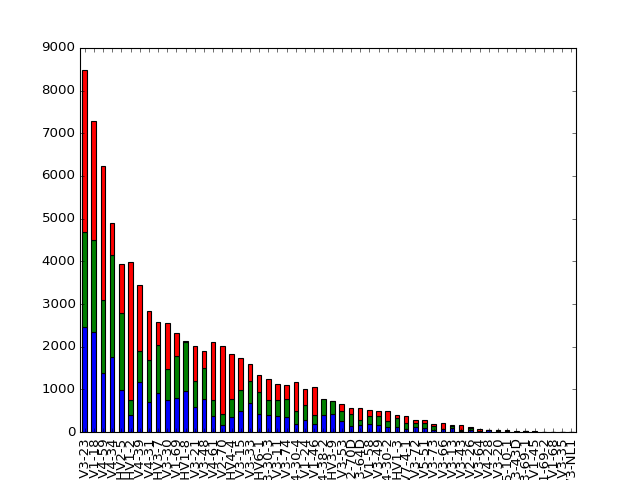

<IPython.core.display.Javascript object>


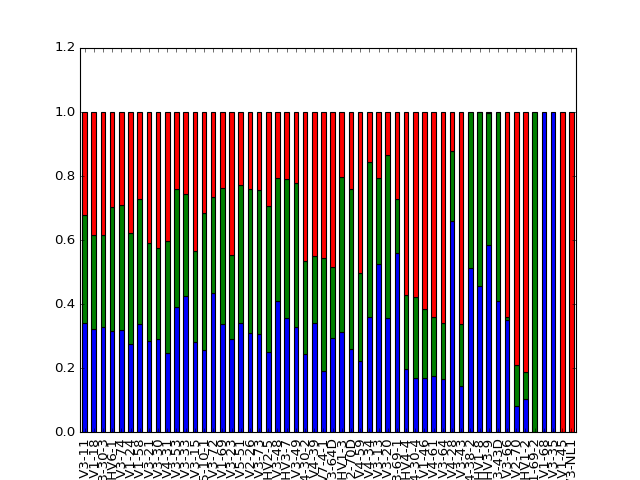

In [156]:

def var_by_indiv_plots(summary_df, var="V-GENE", cell_type=None, day=None):
    # Filter out relevant cell types and days
    if cell_type and all((x in ["plasma", "MBC", "PBMCs"]) for x in cell_type): 
        summary_df = summary_df[summary_df["cell_type"].isin(cell_type)]
    if day and all((x in [0, 63, 140]) for x in day): 
        summary_df = summary_df[summary_df["day"].isin(day)]
        
    # Calculate normalised abundance of V genes by patient at day 0
    v_d0 = summary_df.groupby([var, "patient_code"]).sum()["norm_factor"].unstack().fillna(0)
    # Convert to proportion of repertoire
    v_d0_prop = v_d0.apply(lambda x: x/np.sum(x), axis=0)

    # Order V genes by total proportion of repertoire represented and plot
    v_d0_total_prop_idx = v_d0_prop.sum(axis=1).sort_values(ascending=False).index
    v_d0.loc[v_d0_total_prop_idx, :].plot(kind="bar", stacked=True, legend=None)
    # Normalise by total proportion of repertoire represented and replot
    # v_d0.loc[v_d0_total_prop_idx, :].apply(lambda x: x/np.sum(x), axis=1).plot(kind="bar", stacked=True, legend=None)

    # Order V genes by coefficent of variation and plot
    v_d0_cv_idx = v_d0.apply(lambda x: np.std(x)/np.mean(x), axis=1).sort_values().index
    v_d0.loc[v_d0_cv_idx, :].apply(lambda x: x/np.sum(x), axis=1).plot(kind="bar", stacked=True, legend=None)

#
# Day 0: distribution of clonotypes between individuals
#

var_by_indiv_plots(summary_df, var="V-GENE", day=[0])
# var_by_indiv_plots(summary_df, var="V-GENE", cell_type=["plasma"], day=[0]) 
# var_by_indiv_plots(summary_df, var="V-GENE", cell_type=["MBC"], day=[0]) 
# var_by_indiv_plots(summary_df, var="V-GENE", cell_type=["PBMCs"], day=[0]) 


In [282]:
#
# Day 140: characterisation of long term memory
# In the memory compartment:
#     - increase in abundance from d0 to post prime: d28 > d0
#     - recalled at post boost (day 63): d63 > d0
#     - still present at d140: d140 > d0
#     - relatively high mutational freq (i.e. is the above group higher than expected)
#
# Compare against the naive repertoire:
#     IgD/IgM unmutated sequences taken from PBMC samples

def get_v_gene_freq(summary_df):
    '''For each V gene present, get normalised usage
    '''
    return summary_df.groupby("V-GENE")["norm_factor"].sum()

def get_isotype_freq(summary_df):
    '''For each isotype present, get normalised freq
    '''
    isotype_freqs = defaultdict(float)
    for isotypes, norm_factors in zip(summary_df["isotypes"], summary_df["norm_factor"]):
        for isotype in isotypes:
            isotype_freqs[isotype] += norm_factors
    return pd.Series(isotype_freqs)

def get_clonotype_freq(summary_df):
    '''For each clonotype present, get normalised abundance
    '''
    return summary_df.groupby("clonotype")["norm_factor"].sum()

def get_naive_rep(summary_df):
    '''Filter for the naive repertoire
    '''
    return summary_df.loc[(summary_df["V-REGION identity %"] == 100) 
                          & (summary_df["digest"].map(lambda x: "IGHM" in x or "IGHG" in x))
                          & (summary_df["cell_type"] == "PBMCs")]

# Find V-genes that increased in abundance from day 0

# Get naive rep from day 0 
naive_d0 = get_naive_rep(summary_df).query("day == 0")

# Get plasmoblast rep from day 63
plasma_d63 = summary_df.query("day == 63 & cell_type == 'plasma'")

# Get memory rep from day 140
mbc_d140 = summary_df.query("day == 140 & cell_type == 'MBC'")




In [324]:
naive_d0

,day,sample_num,Sequence number,Sequence ID,digest,Functionality,V-GENE and allele,V-REGION score,V-REGION identity %,V-REGION identity nt,...,CDR3_len,clonotype,Tag Index,patient_code,cell_type,norm_factor,Ab.Name,V-GENE_known_usage,isotypes,n_isotypes
4754,0,22,15,MS7_2015411105922222599__0_0_0_0_0_0_0_0_0_0_0...,IGHM,productive,Homsap IGHV3-11*06 F,980.0,100.0,197/197 nt,...,14,IGHV3-11.IGHJ4.14,22,2207,PBMCs,0.963282,NaN,NaN,[IGHM],1
4755,0,22,16,MS7_20154111012902617334__0_0_0_0_0_0_0_0_0_0_...,IGHM,productive,Homsap IGHV1-18*01 F,960.0,100.0,193/193 nt,...,17,IGHV1-18.IGHJ3.17,22,2207,PBMCs,0.963282,NaN,IGHV1-18,[IGHM],1
4756,0,22,17,MS7_201541210874109539__0_0_0_0_0_0_0_0_0_0_0_...,IGHM,productive,Homsap IGHV1-2*02 F,960.0,100.0,193/193 nt,...,15,IGHV1-2.IGHJ6.15,22,2207,PBMCs,0.963282,NaN,IGHV1-2,[IGHM],1
4765,0,22,26,MS7_20154121081320322298__0_0_0_0_0_0_0_0_0_0_...,IGHM,productive,"Homsap IGHV4-59*01 F, or Homsap IGHV4-59*07 F",1095.0,100.0,220/220 nt,...,17,IGHV4-59.IGHJ6.17,22,2207,PBMCs,0.963282,NaN,NaN,[IGHM],1
4772,0,22,34,MS7_20154121071756018548__0_0_0_0_0_0_0_0_0_0_...,IGHM,productive,Homsap IGHV4-30-2*01 F,1125.0,100.0,226/226 nt,...,16,IGHV4-30-2.IGHJ5.16,22,2207,PBMCs,0.963282,NaN,NaN,[IGHM],1
4779,0,22,41,MS7_20154111052154714452__0_0_0_0_0_0_0_0_0_0_...,IGHM,productive,Homsap IGHV1-2*02 F,960.0,100.0,193/193 nt,...,20,IGHV1-2.IGHJ4.20,22,2207,PBMCs,0.963282,NaN,IGHV1-2,[IGHM],1
4781,0,22,43,MS7_2015411117718617666__0_0_0_0_0_0_0_0_0_0_0...,IGHM,productive,"Homsap IGHV4-31*03 F, or Homsap IGHV4-31*04 F",1125.0,100.0,226/226 nt,...,14,IGHV4-31.IGHJ4.14,22,2207,PBMCs,0.963282,NaN,IGHV4-31,[IGHM],1
4787,0,22,49,MS7_20154111081516316673__0_0_0_0_0_0_0_0_0_0_...,IGHM,productive,Homsap IGHV2-70*01 F,1240.0,100.0,249/249 nt,...,19,IGHV2-70.IGHJ3.19,22,2207,PBMCs,0.963282,NaN,NaN,[IGHM],1
4795,0,22,57,MS7_201541211786229567__0_0_0_0_0_0_0_0_0_0_0_...,IGHM,productive,"Homsap IGHV4-39*01 F, or Homsap IGHV4-39*05 F",1125.0,100.0,226/226 nt,...,12,IGHV4-39.IGHJ3.12,22,2207,PBMCs,0.963282,NaN,IGHV4-39,[IGHM],1
4797,0,22,59,MS7_20154111031698917968__0_0_0_0_0_0_0_0_0_0_...,IGHM,productive,"Homsap IGHV4-59*01 F, or Homsap IGHV4-59*07 F",1095.0,100.0,220/220 nt,...,20,IGHV4-59.IGHJ4.20,22,2207,PBMCs,0.963282,NaN,NaN,[IGHM],1


(51, 3)


<IPython.core.display.Javascript object>


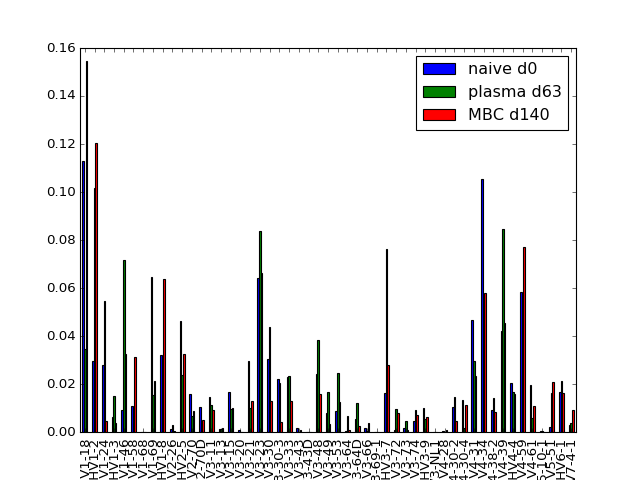

In [296]:
foo = pd.concat([get_v_gene_freq(naive_d0), 
           get_v_gene_freq(plasma_d63),
           get_v_gene_freq(mbc_d140)], axis=1)
foo.columns = ["naive d0", "plasma d63", "MBC d140"] 
print(foo.shape)
foo.apply(lambda x: x/np.sum(x)).plot(kind="bar")

In [281]:
get_v_gene_freq(summary_df.query("day == 140 & cell_type == 'MBC'"))

V-GENE
IGHV1-18      2778.453399
IGHV1-2       2170.012583
IGHV1-24        81.603813
IGHV1-3         68.940162
IGHV1-46       588.379661
IGHV1-58       559.771905
IGHV1-69       378.584777
IGHV1-8       1145.457737
IGHV2-26         6.964219
IGHV2-5        581.679516
IGHV2-70       156.961871
IGHV2-70D       86.860854
IGHV3-11       162.891912
IGHV3-13        27.925302
IGHV3-15       177.042649
IGHV3-20         1.932605
IGHV3-21       234.425277
IGHV3-23      1190.057658
IGHV3-30       234.378671
IGHV3-30-3      75.722764
IGHV3-33       234.232015
IGHV3-43        17.278036
IGHV3-43D        1.932605
IGHV3-48       283.238061
IGHV3-49        63.317667
IGHV3-53       224.852873
IGHV3-64        15.460837
IGHV3-64D       46.119155
IGHV3-66        68.039326
IGHV3-69-1       1.166405
IGHV3-7        500.202962
IGHV3-72       142.099850
IGHV3-73        11.410503
IGHV3-74       128.178458
IGHV3-9        110.066171
IGHV3-NL1        1.166405
IGHV4-28        18.628272
IGHV4-30-2      79.428924
IGHV4

In [278]:
# How many clonotypes and V-genes overlap with those from known mAbs?
print(summary_df.query("day == 140 & cell_type == 'MBC'")["Ab.Name"].value_counts(dropna=False))
print(summary_df.query("day == 140 & cell_type == 'MBC'")["V-GENE_known_usage"].value_counts(dropna=False))

NaN       17440
R5.001      395
R5.019       41
R5.003       38
R5.013       26
R5.008       16
R5.006        8
R5.018        4
R5.007        4
R5.016        4
R5.015        3
R5.009        3
R5.004        2
Name: Ab.Name, dtype: int64
NaN          8249
IGHV1-2      3548
IGHV1-18     2497
IGHV3-23      917
IGHV4-39      626
IGHV4-31      618
IGHV1-69      378
IGHV3-7       372
IGHV5-51      311
IGHV3-33      201
IGHV7-4-1     142
IGHV3-9        74
IGHV3-49       51
Name: V-GENE_known_usage, dtype: int64


In [297]:
summary_df


,day,sample_num,Sequence number,Sequence ID,digest,Functionality,V-GENE and allele,V-REGION score,V-REGION identity %,V-REGION identity nt,...,CDR3_len,clonotype,Tag Index,patient_code,cell_type,norm_factor,Ab.Name,V-GENE_known_usage,isotypes,n_isotypes
0,0,16,1,MS7_20154111092026411880__0_0_0_0_0_1_0_0_0_0_...,IGHG1,productive,"Homsap IGHV3-23*01 F, or Homsap IGHV3-23*04 F ...",845.0,92.39,182/197 nt,...,23,IGHV3-23.IGHJ3.23,16,2207,plasma,1.188326,NaN,IGHV3-23,[IGHG1],1
1,0,16,2,MS7_20154111042072910943__1_0_0_0_0_0_0_0_0_0_...,IGHA1,productive,Homsap IGHV1-18*01 F,852.0,93.78,181/193 nt,...,14,IGHV1-18.IGHJ4.14,16,2207,plasma,1.188326,NaN,IGHV1-18,[IGHA1],1
2,0,16,3,MS7_2015411101802120649__0_0_0_0_0_0_1_0_0_0_0...,IGHG2,productive,Homsap IGHV1-2*02 F,960.0,100.00,193/193 nt,...,13,IGHV1-2.IGHJ5.13,16,2207,plasma,1.188326,NaN,IGHV1-2,[IGHG2],1
3,0,16,4,MS7_20154111121956212740__0_0_0_0_0_0_0_0_0_0_...,IGHM,productive,Homsap IGHV2-70*01 F,1177.0,97.19,242/249 nt,...,20,IGHV2-70.IGHJ6.20,16,2207,plasma,1.188326,NaN,NaN,[IGHM],1
4,0,16,5,MS7_2015411107256174723__0_0_0_0_0_1_0_0_0_0_0...,IGHG1,productive,Homsap IGHV4-30-4*01 F,828.0,85.40,193/226 nt,...,18,IGHV4-30-4.IGHJ4.18,16,2207,plasma,1.188326,NaN,NaN,[IGHG1],1
5,0,16,6,MS7_20154111102474611152__0_0_0_0_0_0_0_0_0_0_...,IGHM,productive,Homsap IGHV3-49*04 F,911.0,94.58,192/203 nt,...,15,IGHV3-49.IGHJ3.15,16,2207,plasma,1.188326,NaN,IGHV3-49,[IGHM],1
6,0,16,7,MS7_201541110596759208__0_0_0_0_0_0_0_0_0_0_0_...,IGHM,productive,Homsap IGHV3-48*03 F,917.0,96.45,190/197 nt,...,14,IGHV3-48.IGHJ4.14,16,2207,plasma,1.188326,NaN,NaN,[IGHM],1
7,0,16,8,MS7_2015412117448121042__0_0_0_0_0_1_0_0_0_0_0...,IGHG1,productive,"Homsap IGHV3-23*01 F, or Homsap IGHV3-23*04 F ...",854.0,92.89,183/197 nt,...,23,IGHV3-23.IGHJ3.23,16,2207,plasma,1.188326,NaN,IGHV3-23,[IGHG1],1
8,0,16,9,MS7_20154111191727013216__0_1_0_0_0_0_0_0_0_0_...,IGHA2,productive,"Homsap IGHV4-4*02 F, or Homsap IGHV4-4*03 F or...",930.0,91.03,203/223 nt,...,10,IGHV4-4.IGHJ5.10,16,2207,plasma,1.188326,NaN,NaN,[IGHA2],1
9,0,16,10,MS7_201541211749108038__1_0_0_0_0_0_0_0_0_0_0_...,IGHA1,productive,"Homsap IGHV1-2*02 F, or Homsap IGHV1-2*05 F",861.0,94.30,182/193 nt,...,14,IGHV1-2.IGHJ4.14,16,2207,plasma,1.188326,NaN,IGHV1-2,[IGHA1],1


In [304]:
print(summary_df["V-GENE"].unique().size)
print(summary_df["clonotype"].unique().size)

58
4661


In [322]:
bar = summary_df.groupby("sample_num").apply(lambda x: x.groupby("clonotype")["norm_factor"].sum())[1]
sorted(bar)

[2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,
 2.240713189042483,


In [323]:
baz = summary_df.groupby("sample_num").apply(lambda x: x["clonotype"].value_counts()[1])
sorted(baz)

[21,
 26,
 26,
 35,
 37,
 38,
 54,
 68,
 78,
 82,
 92,
 94,
 115,
 166,
 204,
 220,
 257,
 386,
 540,
 618,
 640,
 808]